
# 🚗 Uber Supply–Demand Gap Analysis — Week 3 (Labmentix)
**Author:** Gouri  
**Date:** 2025-10-29  
**Dataset:** `Uber Request Data.csv`

---

### Objective
Analyze Uber ride request data to identify supply-demand gaps by time and location, extract actionable insights, and present results in a clear, internship-ready format.


In [3]:

# 1) Imports & Load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

pd.set_option('display.max_columns', None)
df = pd.read_csv('Uber Request Data.csv')
print('Loaded shape:', df.shape)
df.head()


Loaded shape: (6745, 6)


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [4]:

# 2) Quick overview
print('Columns:', df.columns.tolist())
print('\nMissing values per column:\n', df.isnull().sum())
print('\nSample value counts for Status:\n', df['Status'].value_counts(dropna=False).head(10))


Columns: ['Request id', 'Pickup point', 'Driver id', 'Status', 'Request timestamp', 'Drop timestamp']

Missing values per column:
 Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

Sample value counts for Status:
 Status
Trip Completed       2831
No Cars Available    2650
Cancelled            1264
Name: count, dtype: int64


In [5]:

# 3) Cleaning & Timestamp parsing
df.columns = [c.strip() for c in df.columns]
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

# Find likely time columns
time_cols = [c for c in df.columns if 'timestamp' in c.lower() or 'time' in c.lower()]
time_cols


['Request timestamp', 'Drop timestamp']

In [6]:

# 4) Parse request timestamp & feature engineering
req_col = next((c for c in df.columns if 'request' in c.lower() and 'time' in c.lower()), None)
if req_col is None:
    req_col = next((c for c in df.columns if 'timestamp' in c.lower()), None)

print('Request column used:', req_col)
df[req_col] = pd.to_datetime(df[req_col], errors='coerce', infer_datetime_format=True)
df['request_dt'] = df[req_col]
df['request_hour'] = df['request_dt'].dt.hour
df['request_dayname'] = df['request_dt'].dt.day_name()

def time_slot(h):
    if pd.isna(h): return 'Unknown'
    h = int(h)
    if 5 <= h < 9:
        return 'Early Morning (5-9)'
    if 9 <= h < 12:
        return 'Morning (9-12)'
    if 12 <= h < 17:
        return 'Afternoon (12-17)'
    if 17 <= h < 21:
        return 'Evening (17-21)'
    if 21 <= h or h < 1:
        return 'Night (21-1)'
    return 'Late Night (1-5)'

df['time_slot'] = df['request_hour'].apply(time_slot)
df[['request_dt','request_hour','time_slot']].head()


Request column used: Request timestamp


C:\Users\sunil\AppData\Local\Temp\ipykernel_16352\267657698.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[req_col] = pd.to_datetime(df[req_col], errors='coerce', infer_datetime_format=True)


,request_dt,request_hour,time_slot
0,2016-11-07 11:51:00,11.0,Morning (9-12)
1,2016-11-07 17:57:00,17.0,Evening (17-21)
2,2016-12-07 09:17:00,9.0,Morning (9-12)
3,2016-12-07 21:08:00,21.0,Night (21-1)
4,NaT,NaN,Unknown


In [7]:

# 5) Standardize Status values
df['Status'] = df['Status'].astype(str).str.strip()
status_unique = df['Status'].unique()
status_unique[:20]


array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

In [8]:

# Map statuses to categories
status_map = {}
for s in status_unique:
    s_lower = s.lower()
    if s_lower.startswith('trip') or 'completed' in s_lower:
        status_map[s] = 'Trip Completed'
    elif 'cancel' in s_lower:
        status_map[s] = 'Cancelled'
    elif 'no' in s_lower and 'car' in s_lower:
        status_map[s] = 'No Cars Available'
    else:
        status_map[s] = s

df['Status_clean'] = df['Status'].map(status_map)
df['Status_clean'].value_counts()


Status_clean
Trip Completed       2831
No Cars Available    2650
Cancelled            1264
Name: count, dtype: int64

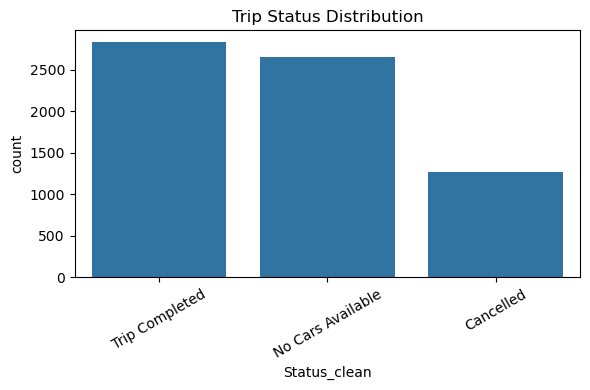

Status_clean
Trip Completed       41.97
No Cars Available    39.29
Cancelled            18.74
Name: proportion, dtype: float64

In [9]:

# 6) EDA - Status distribution
plt.figure(figsize=(6,4))
order = df['Status_clean'].value_counts().index
sns.countplot(data=df, x='Status_clean', order=order)
plt.title('Trip Status Distribution')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

status_pct = df['Status_clean'].value_counts(normalize=True).mul(100).round(2)
status_pct


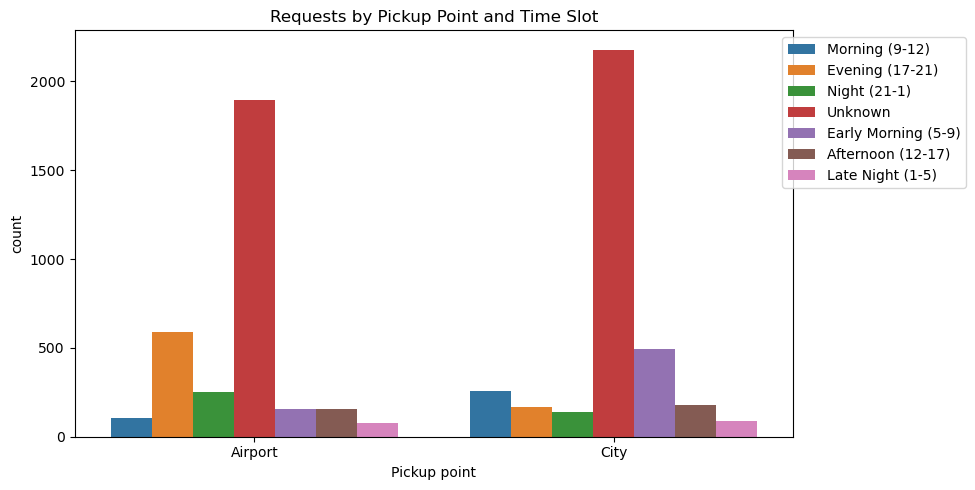

In [10]:

# 7) Requests by Pickup point and Time Slot
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Pickup point', hue='time_slot', palette='tab10')
plt.title('Requests by Pickup Point and Time Slot')
plt.xticks(rotation=0)
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1))
plt.tight_layout()
plt.show()


In [11]:

# 8) Supply-Demand gap calculation
group = df.groupby(['Pickup point','time_slot','Status_clean']).size().unstack(fill_value=0).reset_index()
group['total_requests'] = group.iloc[:,2:].sum(axis=1)
group['unfulfilled'] = group.get('No Cars Available',0) + group.get('Cancelled',0)
group['unfulfilled_rate'] = (group['unfulfilled'] / group['total_requests']).replace([np.inf, np.nan],0)
group.sort_values('unfulfilled_rate', ascending=False).head(10)


Status_clean,Pickup point,time_slot,Cancelled,No Cars Available,Trip Completed,total_requests,unfulfilled,unfulfilled_rate
2,Airport,Evening (17-21),35,429,127,591,464,0.785110
8,City,Early Morning (5-9),248,112,134,494,360,0.728745
5,Airport,Night (21-1),12,159,82,253,171,0.675889
10,City,Late Night (1-5),20,39,32,91,59,0.648352
6,Airport,Unknown,111,1025,757,1893,1136,0.600106
3,Airport,Late Night (1-5),0,48,32,80,48,0.600000
11,City,Morning (9-12),94,57,106,257,151,0.587549
13,City,Unknown,651,616,911,2178,1267,0.581726
12,City,Night (21-1),15,41,83,139,56,0.402878
7,City,Afternoon (12-17),21,47,110,178,68,0.382022


C:\Users\sunil\AppData\Local\Temp\ipykernel_16352\1387151156.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x='unfulfilled_rate', y='label', palette='Blues_d')


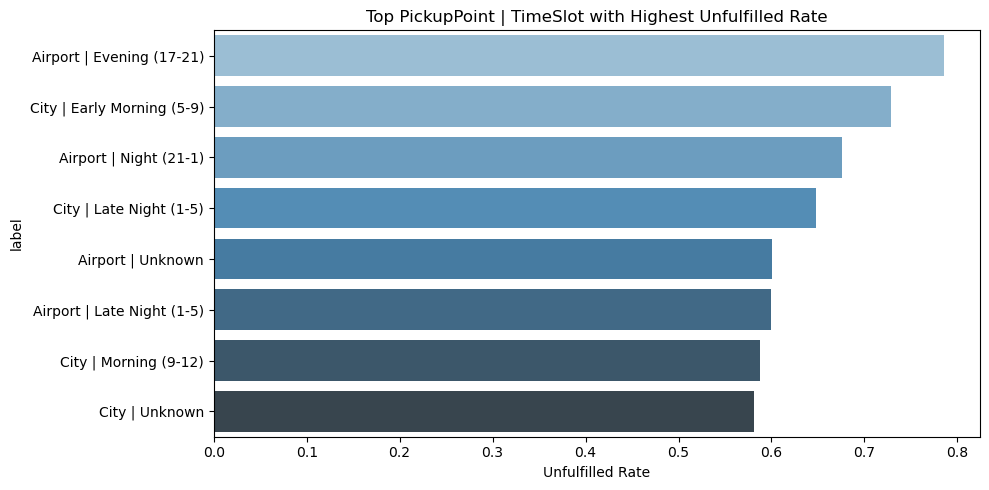

Status_clean,Pickup point,time_slot,total_requests,unfulfilled,unfulfilled_rate
2,Airport,Evening (17-21),591,464,0.785110
8,City,Early Morning (5-9),494,360,0.728745
5,Airport,Night (21-1),253,171,0.675889
10,City,Late Night (1-5),91,59,0.648352
6,Airport,Unknown,1893,1136,0.600106
3,Airport,Late Night (1-5),80,48,0.600000
11,City,Morning (9-12),257,151,0.587549
13,City,Unknown,2178,1267,0.581726


In [12]:

# 9) Plot top 8 Pickup point & time_slot combinations with highest unfulfilled_rate
top = group.sort_values('unfulfilled_rate', ascending=False).head(8).copy()
top['label'] = top['Pickup point'] + ' | ' + top['time_slot']
plt.figure(figsize=(10,5))
sns.barplot(data=top, x='unfulfilled_rate', y='label', palette='Blues_d')
plt.title('Top PickupPoint | TimeSlot with Highest Unfulfilled Rate')
plt.xlabel('Unfulfilled Rate')
plt.tight_layout()
plt.show()

top[['Pickup point','time_slot','total_requests','unfulfilled','unfulfilled_rate']]


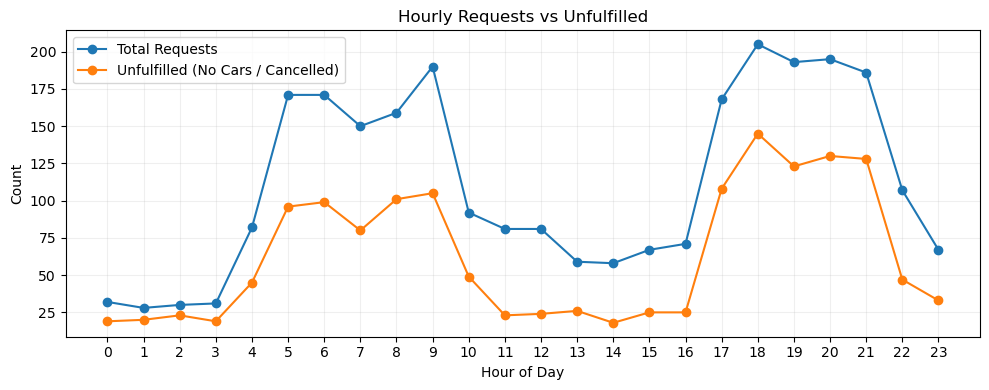

Status_clean,request_hour,Cancelled,No Cars Available,Trip Completed,total,unfulfilled
0,0.0,1,18,13,32,19
1,1.0,3,17,8,28,20
2,2.0,2,21,7,30,23
3,3.0,1,18,12,31,19
4,4.0,14,31,37,82,45


In [13]:

# 10) Hourly trend: requests per hour and unfulfilled counts per hour
hourly = df.groupby(['request_hour','Status_clean']).size().unstack(fill_value=0).reset_index()
hourly['total'] = hourly.drop(columns=['request_hour']).sum(axis=1)
hourly['unfulfilled'] = hourly.get('No Cars Available',0) + hourly.get('Cancelled',0)
hourly = hourly.sort_values('request_hour')
plt.figure(figsize=(10,4))
plt.plot(hourly['request_hour'], hourly['total'], marker='o', label='Total Requests')
plt.plot(hourly['request_hour'], hourly['unfulfilled'], marker='o', label='Unfulfilled (No Cars / Cancelled)')
plt.xticks(range(0,24))
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Hourly Requests vs Unfulfilled')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

hourly.head()



## 🧠 Insights & Recommendations

- **Peak demand hours** can be observed from the hourly trend chart. Focus supply (drivers) during those hours to reduce missed requests.  
- **Top problem slots** (Pickup point + Time slot) with high unfulfilled rates indicate where driver allocation or incentives are needed.  
- **Actions for operations team:** surge pricing, driver incentives near high-gap zones, and improved driver allocation during early mornings/evenings.  
- **Next steps:** integrate driver availability data, apply time-series forecasting for demand, and build an interactive dashboard (Power BI / Plotly) for live monitoring.



## 🔗 LinkedIn Post (copy-paste ready)

🎯 Week 3 — Uber Supply–Demand Gap Analysis 🚗

Completed a data-driven project as part of the Labmentix Data Analytics Internship. Analyzed Uber ride request data to find when and where demand exceeds supply. I performed data cleaning, feature engineering (time slots & hourly trends), and identified top pickup-point/time-slot combinations with high unfulfilled rates. Insights include targeted driver incentives and surge management during peak windows.

Tools: Python, Pandas, Matplotlib, Seaborn, Jupyter Notebook

GitHub: (add your project repo link here)

#DataAnalytics #MachineLearning #Python #Labmentix #DataScience #EDA #UberAnalysis
